In [1]:
import matplotlib.pyplot as plt
import numpy as np
from stop_all import disable_all_power
import pyvisa
from windfreak import SynthHD
import nidaqmx
from nidaqmx.constants import TerminalConfiguration
from NRP50S import NRP50S
from SPD3303X import SPD3303X
from utils import check_voltage, watt_to_dBm
import time
import tqdm
import csv

In [2]:
def read_amplifier_power(channel: int, device: str) -> float:
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan(
            f"{device}/ai{channel}", terminal_config=TerminalConfiguration.DIFF
        )
        return task.read()

In [3]:
def switch_spdt(amplifier: str, channel: int, device: str):
    if amplifier == "vg1":
        voltage = 0
    elif amplifier == "vg2":
        voltage = 5
    else:
        raise ValueError(f"amplifier is {amplifier}; not vg1 or vg2")
        
    with nidaqmx.Task() as task:
        task.ao_channels.add_ao_voltage_chan(
            f"{device}/ao{channel}", min_val = 0, max_val = 5
        )
        task.write(voltage)

In [4]:
def enable_26GHz_power_for_scan(
    psu_vg_5pos: SPD3303X, psu_12pos_vd_5neg: SPD3303X, dt: float = 2
):
    psu_12pos_vd_5neg.ch1_voltage_setpoint = 12
    psu_12pos_vd_5neg.ch1_current_setpoint = 3.0
    psu_12pos_vd_5neg.output(True, 1)
    time.sleep(dt)
    assert check_voltage(psu_12pos_vd_5neg.ch1_voltage, 12.0)

    # enable +/- 5V for the SPDT switches
    psu_vg_5pos.output(True, 3)
    psu_12pos_vd_5neg.output(True, 3)

    # enable amplifiers
    # first set the gate voltage to -1.5V
    psu_vg_5pos.ch1_voltage_setpoint = 1.5
    psu_vg_5pos.ch1_current_setpoint = 0.07

    psu_vg_5pos.ch2_voltage_setpoint = 1.5
    psu_vg_5pos.ch2_current_setpoint = 0.07

    psu_vg_5pos.output(True, 1)
    psu_vg_5pos.output(True, 2)
    time.sleep(dt)
    assert check_voltage(psu_vg_5pos.ch1_voltage, 1.5)
    assert check_voltage(psu_vg_5pos.ch2_voltage, 1.5)

    # turn on the VD = +6V PSU
    psu_12pos_vd_5neg.ch2_voltage_setpoint = 6.0
    psu_12pos_vd_5neg.ch2_current_setpoint = 3.2

    psu_12pos_vd_5neg.output(True, 2)
    time.sleep(dt)
    assert check_voltage(psu_12pos_vd_5neg.ch2_voltage, 6.0)

In [5]:
resource_name_daq = "Dev1"
resource_name_power_meter = "USB0::0x0AAD::0x0161::101074::INSTR"
psu_vg_5pos = "USB0::0xF4EC::0x1430::SPD3XIDX5R3677::INSTR"
psu_12pos_vd_5neg = "USB0::0xF4EC::0x1430::SPD3XIED5R7612::INSTR"
psu_a_5pos = "USB0::0xF4EC::0x1430::SPD3XIED5R8368::INSTR"
resource_name_windfreak = "COM5"

power_meter = NRP50S(resource_name_power_meter)
psu_vg_5pos = SPD3303X(psu_vg_5pos)
psu_12pos_vd_5neg = SPD3303X(psu_12pos_vd_5neg)
psu_a_5pos = SPD3303X(psu_a_5pos)
synthd = SynthHD(resource_name_windfreak)


In [6]:
synthd[1].frequency = 13.3e9
synthd[1].power = 0

# set to vg2
switch_spdt("vg1", 0, resource_name_daq)

power_meter.frequency = synthd[1].frequency*2
power_meter._write("UNIT:POW DBM")

# Vg 1

## without Vg 2 on

In [8]:
power = []
amp_power = []
amp_current = []
v_diff = []

synthd[1].enable = True
enable_26GHz_power_for_scan(psu_vg_5pos, psu_12pos_vd_5neg)

for vg in tqdm.tqdm(np.linspace(1.5, 0.5, 51)):
    psu_vg_5pos.ch1_voltage_setpoint = vg
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    power.append((vg, np.mean(p)))
    amp_power.append((vg, psu_12pos_vd_5neg.ch2_power))
    amp_current.append((vg, psu_12pos_vd_5neg.ch2_current))
    v_diff.append((vg, read_amplifier_power(0, resource_name_daq)))

disable_all_power(psu_vg_5pos, psu_12pos_vd_5neg, psu_a_5pos)
synthd[1].enable = False

100%|██████████| 51/51 [02:10<00:00,  2.57s/it]


In [9]:
with open("2023_2_9_vg1_no_vg2.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["vg [V]", "det power [dBm]", "amp current [A]", "amp power [W]", "v diff [V]"])
    vg, p = np.asarray(list(zip(*power)))
    p += 20 # add 20 dBm because of directional coupler
    _, c = np.asarray(list(zip(*amp_current)))
    _, pa = np.asarray(list(zip(*amp_power)))
    _, vdiff = np.asarray(list(zip(*v_diff)))
    for row in zip(vg, p, c, pa, vdiff):
        writer.writerow(row)

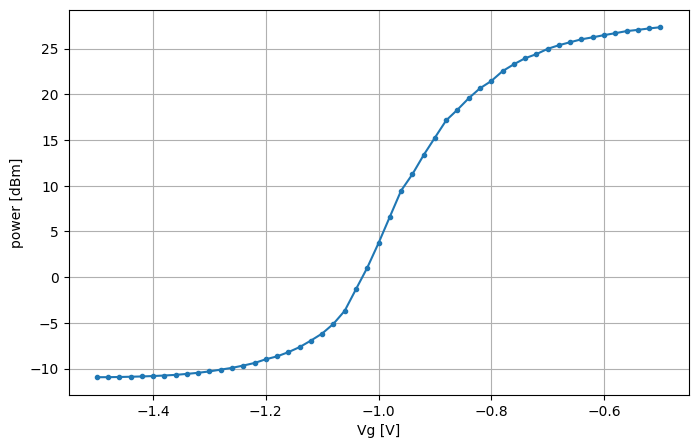

In [10]:
x, y = np.asarray(list(zip(*power)))
y += 20
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(-x,y, '.-')

ax.set_xlabel("Vg [V]")
ax.set_ylabel("power [dBm]")
ax.grid(True)

power_dBm = y.copy()

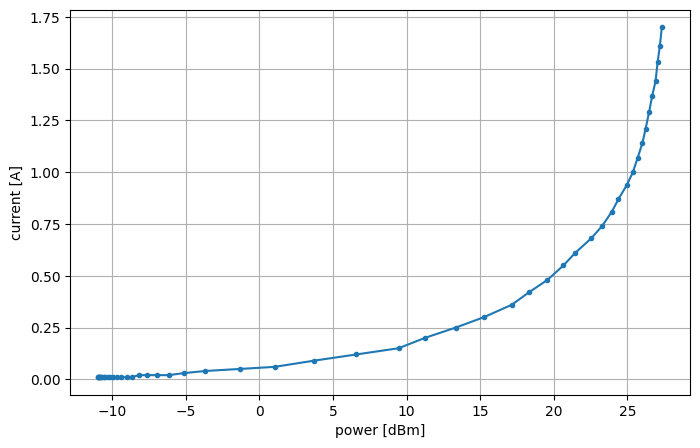

In [11]:
x, y = np.asarray(list(zip(*amp_current)))
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(power_dBm,y, '.-')
ax.set_xlabel("power [dBm]")
ax.set_ylabel("current [A]")
ax.grid(True)

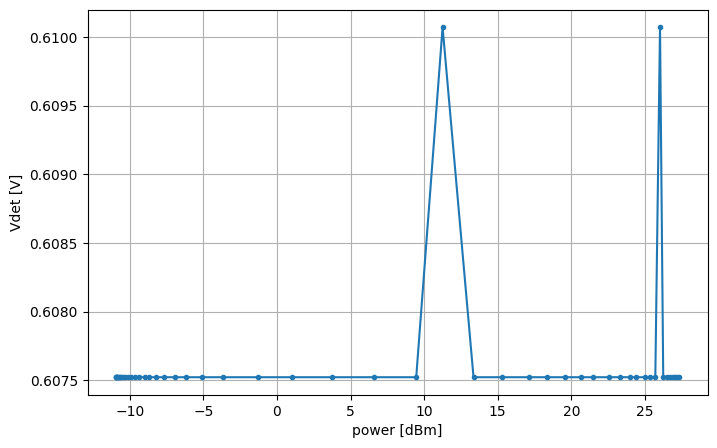

In [12]:
x, y = np.asarray(list(zip(*v_diff)))
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(power_dBm,y, '.-')
ax.set_xlabel("power [dBm]")
ax.set_ylabel("Vdet [V]")
ax.grid(True)

## With Vg 2 on

In [13]:
power = []
amp_power = []
amp_current = []
v_diff = []

synthd[1].enable = True
enable_26GHz_power_for_scan(psu_vg_5pos, psu_12pos_vd_5neg)
psu_vg_5pos.ch2_voltage_setpoint = 0.6

for vg in tqdm.tqdm(np.linspace(1.5, 0.5, 51)):
    psu_vg_5pos.ch1_voltage_setpoint = vg
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    power.append((vg, np.mean(p)))
    amp_power.append((vg, psu_12pos_vd_5neg.ch2_power))
    amp_current.append((vg, psu_12pos_vd_5neg.ch2_current))
    v_diff.append((vg, read_amplifier_power(0, resource_name_daq)))

psu_vg_5pos.ch2_voltage_setpoint = 1.5

disable_all_power(psu_vg_5pos, psu_12pos_vd_5neg, psu_a_5pos)
synthd[1].enable = False


100%|██████████| 51/51 [02:10<00:00,  2.57s/it]


In [14]:
with open("2023_2_9_vg1_vg2.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["vg [V]", "det power [dBm]", "amp current [A]", "amp power [W]", "v diff [V]"])
    vg, p = np.asarray(list(zip(*power)))
    p += 20 # add 20 dBm because of directional coupler
    _, c = np.asarray(list(zip(*amp_current)))
    _, pa = np.asarray(list(zip(*amp_power)))
    _, vdiff = np.asarray(list(zip(*v_diff)))
    for row in zip(vg, p, c, pa, vdiff):
        writer.writerow(row)

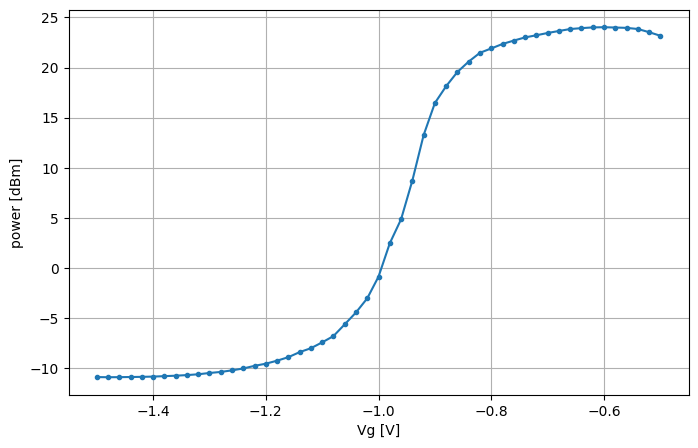

In [15]:
x, y = np.asarray(list(zip(*power)))
y += 20
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(-x,y, '.-')

ax.set_xlabel("Vg [V]")
ax.set_ylabel("power [dBm]")
ax.grid(True)

power_dBm = y.copy()

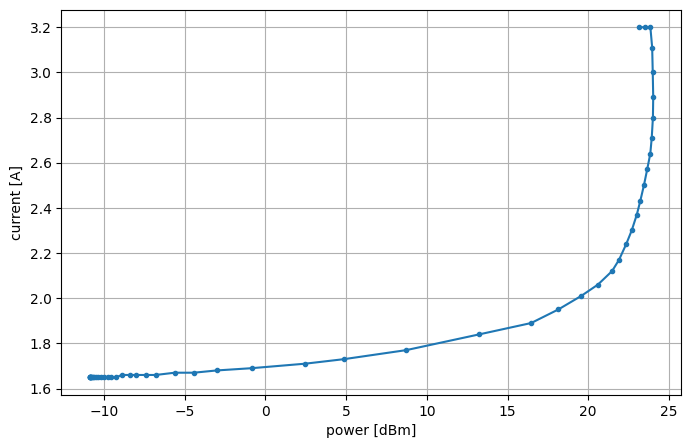

In [16]:
x, y = np.asarray(list(zip(*amp_current)))
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(power_dBm,y, '.-')
ax.set_xlabel("power [dBm]")
ax.set_ylabel("current [A]")
ax.grid(True)

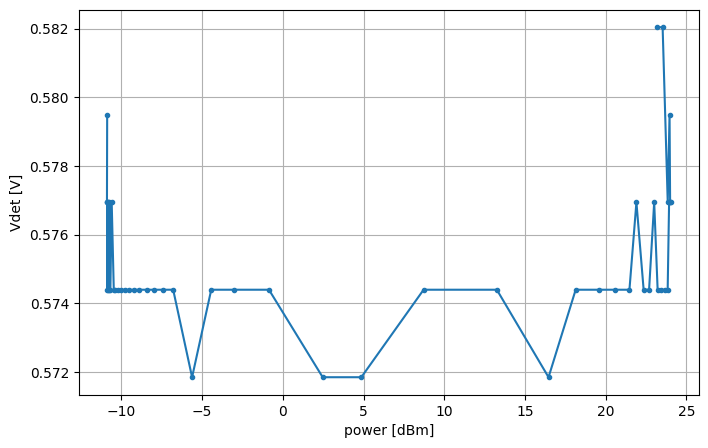

In [17]:
x, y = np.asarray(list(zip(*v_diff)))
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(power_dBm,y, '.-')
ax.set_xlabel("power [dBm]")
ax.set_ylabel("Vdet [V]")
ax.grid(True)

## Scan generator output power

In [18]:
power = []
amp_power = []
amp_current = []
v_diff = []

synthd[1].enable = True
enable_26GHz_power_for_scan(psu_vg_5pos, psu_12pos_vd_5neg)
psu_vg_5pos.ch1_voltage_setpoint = 0.8

for gen_power in tqdm.tqdm(np.linspace(-20,2,51)):
    synthd[1].power = gen_power
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    power.append((gen_power, np.mean(p)))
    amp_power.append((gen_power, psu_12pos_vd_5neg.ch2_power))
    amp_current.append((gen_power, psu_12pos_vd_5neg.ch2_current))
    v_diff.append((gen_power, read_amplifier_power(0, resource_name_daq)))

disable_all_power(psu_vg_5pos, psu_12pos_vd_5neg, psu_a_5pos)
synthd[1].enable = False

100%|██████████| 51/51 [02:11<00:00,  2.58s/it]


In [19]:
with open("2023_2_9_vg1_no_vg2_synth_power_scan_n08Vg.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["synthd power [dBm]", "det power [dBm]", "amp current [A]", "amp power [W]", "v diff [V]"])
    vg, p = np.asarray(list(zip(*power)))
    p += 20 # add 20 dBm because of directional coupler
    _, c = np.asarray(list(zip(*amp_current)))
    _, pa = np.asarray(list(zip(*amp_power)))
    _, vdiff = np.asarray(list(zip(*v_diff)))
    for row in zip(vg, p, c, pa, vdiff):
        writer.writerow(row)

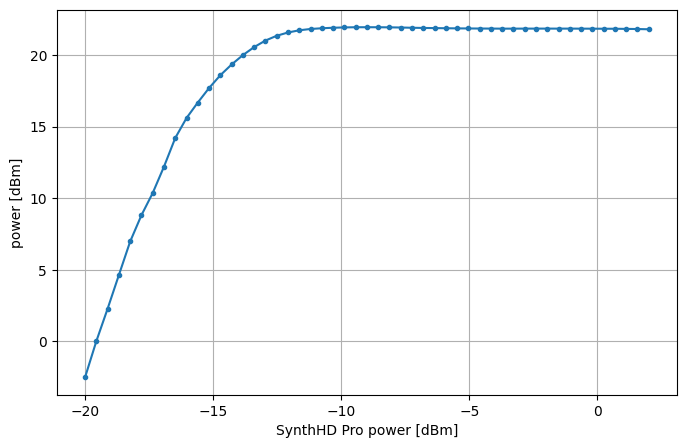

In [20]:
x, y = np.asarray(list(zip(*power)))
y += 20

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x,y, '.-')

ax.set_xlabel("SynthHD Pro power [dBm]")
ax.set_ylabel("power [dBm]")
ax.grid(True)

power_dBm = y.copy()

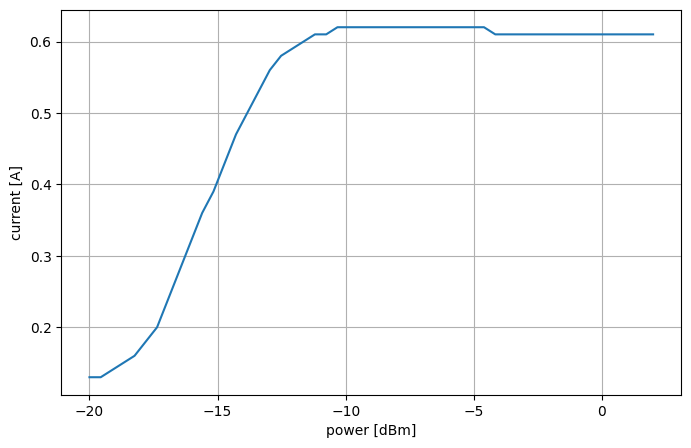

In [21]:
x, y = np.asarray(list(zip(*amp_current)))

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x,y)
ax.set_xlabel("power [dBm]")
ax.set_ylabel("current [A]")
ax.grid(True)

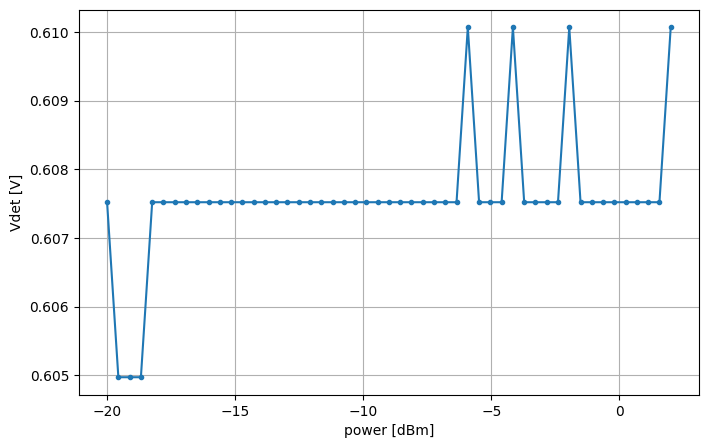

In [22]:
x, y = np.asarray(list(zip(*v_diff)))
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(x,y, '.-')
ax.set_xlabel("power [dBm]")
ax.set_ylabel("Vdet [V]")
ax.grid(True)

## Scan VG1 and VG2

In [30]:
power = []
amp_power = []
amp_current = []

# set to vg1
switch_spdt("vg1", 0, resource_name_daq)
synthd[1].enable = True
enable_26GHz_power_for_scan(psu_vg_5pos, psu_12pos_vd_5neg)

for vg1 in tqdm.tqdm(np.linspace(1.5, 0.5, 41)):
    for vg2 in np.linspace(1.5, 0.5, 41):
        psu_vg_5pos.ch1_voltage_setpoint = vg1
        psu_vg_5pos.ch2_voltage_setpoint = vg2
        p = []
        for _ in range(5):
            power_meter._write("RST")
            power_meter.initiate()
            time.sleep(0.5)
            p.append(power_meter.fetch())
        power.append((vg1, vg2, np.mean(p)))
        amp_power.append((vg1, vg2, psu_12pos_vd_5neg.ch2_power))
        amp_current.append((vg1, vg2, psu_12pos_vd_5neg.ch2_current))

psu_vg_5pos.ch1_voltage_setpoint = 1.5
psu_vg_5pos.ch2_voltage_setpoint = 1.5

disable_all_power(psu_vg_5pos, psu_12pos_vd_5neg, psu_a_5pos)
synthd[1].enable = False


100%|██████████| 41/41 [1:11:40<00:00, 104.88s/it]


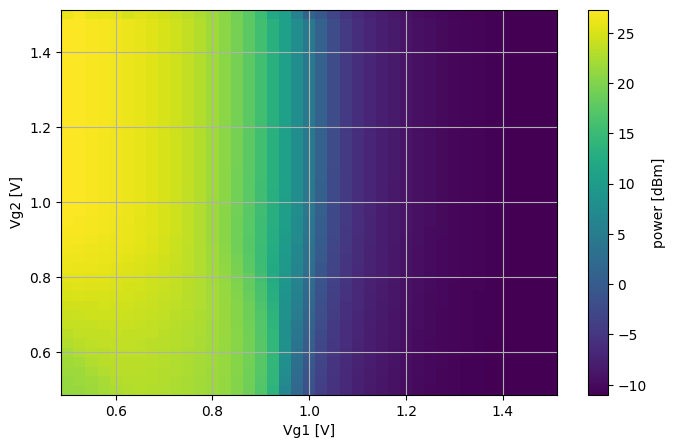

In [45]:
x,y,z = np.asarray(list(zip(*power)))

x = np.reshape(x, (41,41))
y = np.reshape(y, (41,41))
z = np.reshape(z, (41,41)) + 20

fig, ax = plt.subplots(figsize = (8,5))
c = ax.pcolormesh(x,y,z)
ax.set_xlabel("Vg1 [V]")
ax.set_ylabel("Vg2 [V]")

cbar = fig.colorbar(c)
cbar.ax.set_ylabel("power [dBm]")
ax.grid(True)

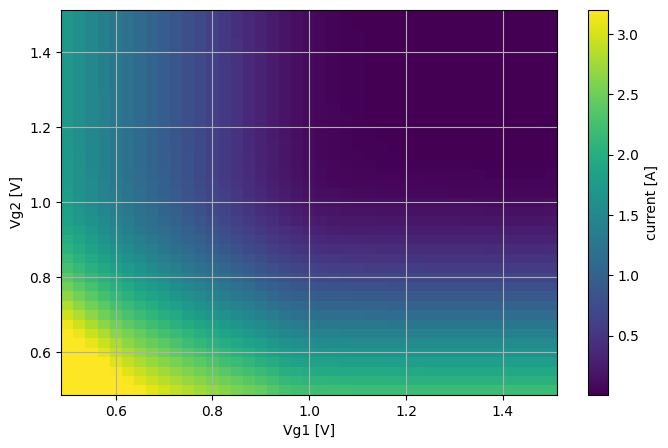

In [58]:
x,y,z = np.asarray(list(zip(*amp_current)))

x = np.reshape(x, (41,41))
y = np.reshape(y, (41,41))
z = np.reshape(z, (41,41))

fig, ax = plt.subplots(figsize = (8,5))
c = ax.pcolormesh(x,y,z)
ax.set_xlabel("Vg1 [V]")
ax.set_ylabel("Vg2 [V]")

cbar = fig.colorbar(c)
cbar.ax.set_ylabel("current [A]")
ax.grid(True)

In [56]:
with open("2023_2_9_vg1_vg2_scan_both.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["vg1 [V]", "vg2 [V]", "det power [dBm]", "amp current [A]", "amp power [W]"])
    vg1, vg2, p = np.asarray(list(zip(*power)))
    p += 20 # add 20 dBm because of directional coupler
    _, _, c = np.asarray(list(zip(*amp_current)))
    _, _, pa = np.asarray(list(zip(*amp_power)))
    for row in zip(vg1, vg2, p, c, pa):
        writer.writerow(row)

## Scan Vg1 and SyntHD Pro Power

In [7]:
power = []
amp_power = []
amp_current = []

# set to vg2
switch_spdt("vg1", 0, resource_name_daq)

synthd[1].power = 0
synthd[1].enable = True
enable_26GHz_power_for_scan(psu_vg_5pos, psu_12pos_vd_5neg)

for shdpower in tqdm.tqdm(np.linspace(-25, 5, 51)):
    synthd[1].power = shdpower
    for vg1 in np.linspace(1.5, 0.5, 41):
        psu_vg_5pos.ch1_voltage_setpoint = vg1
        p = []
        for _ in range(5):
            power_meter._write("RST")
            power_meter.initiate()
            time.sleep(0.5)
            p.append(power_meter.fetch())
        power.append((shdpower, vg1, np.mean(p)))
        amp_power.append((shdpower, vg1, psu_12pos_vd_5neg.ch2_power))
        amp_current.append((shdpower, vg1, psu_12pos_vd_5neg.ch2_current))

psu_vg_5pos.ch1_voltage_setpoint = 1.5
psu_vg_5pos.ch2_voltage_setpoint = 1.5

disable_all_power(psu_vg_5pos, psu_12pos_vd_5neg, psu_a_5pos)
synthd[1].power = 0
synthd[1].enable = False


100%|██████████| 51/51 [1:29:10<00:00, 104.91s/it]


In [8]:
with open("2023_2_9_synthpower_vg1.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["SynthHD Pro power [dBm]", "vg1 [V]", "det power [dBm]", "amp current [A]", "amp power [W]"])
    shdpower, vg2, p = np.asarray(list(zip(*power)))
    p += 20 # add 20 dBm because of directional coupler
    _, _, c = np.asarray(list(zip(*amp_current)))
    _, _, pa = np.asarray(list(zip(*amp_power)))
    for row in zip(shdpower, vg2, p, c, pa):
        writer.writerow(row)

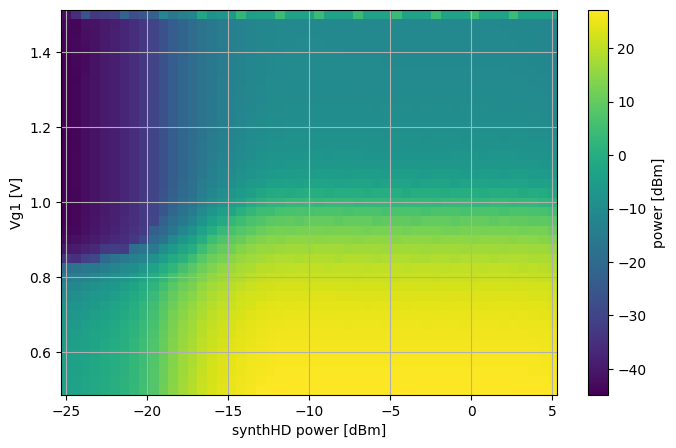

In [11]:
x,y,z = np.asarray(list(zip(*power)))

x = np.reshape(x, (51,41))
y = np.reshape(y, (51,41))
z = np.reshape(z, (51,41)) + 20

fig, ax = plt.subplots(figsize = (8,5))
c = ax.pcolormesh(x,y,z)
ax.set_xlabel("synthHD power [dBm]")
ax.set_ylabel("Vg1 [V]")

cbar = fig.colorbar(c)
cbar.ax.set_ylabel("power [dBm]")
ax.grid(True)

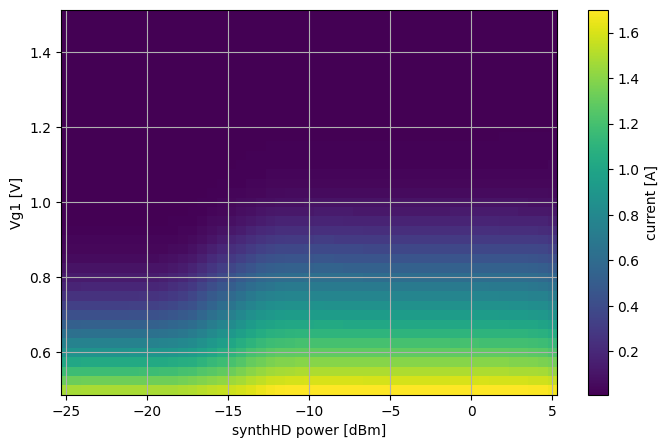

In [10]:
x,y,z = np.asarray(list(zip(*amp_current)))

x = np.reshape(x, (51,41))
y = np.reshape(y, (51,41))
z = np.reshape(z, (51,41))

fig, ax = plt.subplots(figsize = (8,5))
c = ax.pcolormesh(x,y,z)
ax.set_xlabel("synthHD power [dBm]")
ax.set_ylabel("Vg1 [V]")

cbar = fig.colorbar(c)
cbar.ax.set_ylabel("current [A]")
ax.grid(True)